In [1]:
# load package# load p 
import pandas as pd
import numpy as np
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import matplotlib.pyplot as plt


# set path
import os
default_path = "/Users/francislin/Desktop/Machine_Learning_Workshop/esunfrauddetectiongame1809/"
os.chdir(default_path)

# skip interaction warning
import warnings; 
warnings.filterwarnings('ignore')
#你可以选择修改 ast_note_iteractively kernel 选项来使得 Jupyter 为每一行的变量或语句执行这个操作，以便你可以立即看到多条语句一起输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [129]:
train=pd.read_csv('train_diss.csv',encoding='big5')
test=pd.read_csv('test_diss.csv',encoding='big5')
data=train.append(test, ignore_index=True)
#del(train, test)

In [3]:
# calculate max fraud time gap
t1= train[['DATETIME','CANO','FRAUD_IND']]
t1=t1[t1.FRAUD_IND==1]

t_max = t1.groupby(by='CANO', as_index=False).agg({'DATETIME': pd.Series.max})
t_min = t1.groupby(by='CANO', as_index=False).agg({'DATETIME': pd.Series.min})
t_Q = t1.groupby(by='CANO', as_index=False).agg({'DATETIME': pd.Series.nunique})
t_Q.rename(columns={'DATETIME': 'fraud_times'}, inplace=True)

In [4]:
t_time_gap=pd.merge(left=t_max, right=t_min,how='left', on=['CANO'])
t_time_gap=pd.merge(left=t_time_gap, right=t_Q,how='left', on=['CANO'])

In [5]:
t_time_gap.head()

,CANO,DATETIME_x,DATETIME_y,fraud_times
0,848000003,1818041454,1818041454,1
1,882000005,1810482228,1810482228,1
2,1197000007,1831962173,1831962172,2
3,1419000003,1815786230,1815786230,1
4,1445000010,1834837870,1834837870,1


In [6]:
t_time_gap['max_time_gap']= t_time_gap['DATETIME_x']-t_time_gap['DATETIME_y']
t_time_gap= t_time_gap.sort_values(by=['fraud_times','max_time_gap'],ascending=False)#,ascending=False
t_time_gap.head()

,CANO,DATETIME_x,DATETIME_y,fraud_times,max_time_gap
15836,3110951000001,1833607237,1825470619,283,8136618
4369,858936000003,1818762604,1817958119,96,804485
26648,4145636000006,1834687074,1834160432,80,526642
3417,669197000004,1822735981,1809431567,77,13304414
3889,749507000006,1830503200,1830480053,75,23147


In [7]:
len(t_time_gap)
t_time_gap[6500:6505]

33625

,CANO,DATETIME_x,DATETIME_y,fraud_times,max_time_gap
32491,5047727000001,1827859891,1827859837,3,54
17532,3291480000002,1813785862,1813785809,3,53
18899,3430987000002,1823209725,1823209672,3,53
21213,3630615000001,1811861447,1811861394,3,53
32404,5016104000003,1821775669,1821775616,3,53


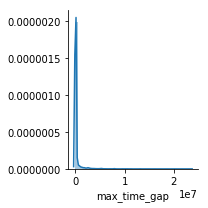

In [8]:
import seaborn as sns
g=sns.FacetGrid(t_time_gap)
g.map(sns.distplot,'max_time_gap',kde=True)#kde是否要折線圖的參數

In [18]:
frq=data[['CANO','MCHNO','DATETIME','ECFG']]

In [22]:
frq.head()
del (t1, t_time_gap, t_max, t_min, t_Q, g)

,CANO,MCHNO,DATETIME,ECFG,CANO_frq_in_5mins,CANO_ECFG_frq_in_5mins
0,2307245000005,012017080000080,1809216040,1,1.0,0.0
1,1363568000002,0100818122,1809216112,1,1.0,0.0
2,1308636000003,210756000200925,1809216311,1,1.0,0.0
3,3162355000001,0100803548,1809216312,1,1.0,0.0
4,3330714000002,210756000200925,1809216316,1,1.0,0.0


In [11]:
%%time
CANO_time = {}
for i in range(0, len(frq)):
    mount = frq.loc[i,'CANO']
    if CANO_time.get(mount) == None:
        CANO_time[mount] = [frq.loc[i,'DATETIME']]
    else:
        CANO_time[mount].append(frq.loc[i,'DATETIME'])

CPU times: user 38.3 s, sys: 174 ms, total: 38.5 s
Wall time: 38.9 s


In [13]:
%%time
MCHNO_time = {}
for i in range(0, len(frq)):
    mount = frq.loc[i,'MCHNO']
    if MCHNO_time.get(mount) == None:
        MCHNO_time[mount] = [frq.loc[i,'DATETIME']]
    else:
        MCHNO_time[mount].append(frq.loc[i,'DATETIME'])

CPU times: user 36.7 s, sys: 57.5 ms, total: 36.8 s
Wall time: 36.8 s


In [12]:
import sys, time # https://blog.csdn.net/u013832707/article/details/73608504

class ShowProcess():
    """
    显示处理进度的类
    调用该类相关函数即可实现处理进度的显示
    """
    i = 0 # 当前的处理进度
    max_steps = 0 # 总共需要处理的次数
    max_arrow = 50 #进度条的长度
    infoDone = 'done'

    # 初始化函数，需要知道总共的处理次数
    def __init__(self, max_steps, infoDone = 'Done'):
        self.max_steps = max_steps
        self.i = 0
        self.infoDone = infoDone

    # 显示函数，根据当前的处理进度i显示进度
    # 效果为[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]100.00%
    def show_process(self, i=None):
        if i is not None:
            self.i = i
        else:
            self.i += 1
        num_arrow = int(self.i * self.max_arrow / self.max_steps) #计算显示多少个'>'
        num_line = self.max_arrow - num_arrow #计算显示多少个'-'
        percent = self.i * 100.0 / self.max_steps #计算完成进度，格式为xx.xx%
        process_bar = '[' + '>' * num_arrow + '-' * num_line + ']'\
                      + '%.2f' % percent + '%' + '\r' #带输出的字符串，'\r'表示不换行回到最左边
        sys.stdout.write(process_bar) #这两句打印字符到终端
        sys.stdout.flush()
        if self.i >= self.max_steps:
            self.close()

    def close(self):
        print('')
        print(self.infoDone)
        self.i = 0
'''
process_bar = ShowProcess(100, 'OK')
for i in range(100):
    process_bar.show_process()
    time.sleep(0.001)
'''

"\nprocess_bar = ShowProcess(100, 'OK')\nfor i in range(100):\n    process_bar.show_process()\n    time.sleep(0.001)\n"

In [23]:
%%time
process_bar = ShowProcess(len(frq), 'OK')
frq['CANO_frq_in_5mins'] = 0
for i in range(0, len(frq)):
    process_bar.show_process()
    time_list = CANO_time.get(frq.loc[i,'CANO'])
    if type(time_list)==list: 
        for t in time_list:
            if abs(t - frq.loc[i,'DATETIME']) < 300:
                frq.loc[i,'CANO_frq_in_5mins'] += 1

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]100.00%
OK
CPU times: user 1d 15min 13s, sys: 24min 56s, total: 1d 40min 10s
Wall time: 1d 20h 14min 22s


In [121]:
%%time
process_bar = ShowProcess(len(frq), 'OK')
frq['CANO_frq_in_1min'] = 0
frq['CANO_ECFG_frq_in_1min'] = 0
for i in range(0, len(frq)):
    process_bar.show_process()
    time_list = CANO_time.get(frq.loc[i,'CANO'])
    if type(time_list)==list: 
        for t in time_list:
            if (frq.loc[i,'DATETIME']-300) < t < (frq.loc[i,'DATETIME']+300):
                frq.loc[i,'CANO_frq_in_1min'] += 1
                if frq.loc[i,'ECFG'] == 1:
                    frq.loc[i,'CANO_ECFG_frq_in_1min'] += 1               

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]100.00%
OK
CPU times: user 2h 46min 37s, sys: 33min 29s, total: 3h 20min 7s
Wall time: 3h 13min 28s


In [126]:
frq.dtypes

CANO                      int64
MCHNO                    object
DATETIME                  int64
ECFG                      int64
CANO_frq_in_5mins          int8
CANO_frq_in_1min           int8
CANO_ECFG_frq_in_1min      int8
dtype: object

In [125]:
frq.CANO_frq_in_1min=frq.CANO_frq_in_1min.astype(np.int8)
frq.CANO_ECFG_frq_in_1min=frq.CANO_ECFG_frq_in_1min.astype(np.int8)

In [127]:
# 匯出pickle
import pickle
with open('frq_detail_CANO_5mins_1min.pickle','wb') as f:
    pickle.dump(frq,f)

In [131]:
data=pd.concat([data,frq[['CANO_frq_in_5mins','CANO_frq_in_1min','CANO_ECFG_frq_in_1min']]], axis=1)

In [136]:
data.ECFG[101]

0

In [137]:
data['s_in_a_Day']= data['DATETIME']%(60*60*24)
import math
data['h_in_a_Day']= data['s_in_a_Day'].map(lambda x: math.floor(x/(60*60)))

In [138]:
'''for a in ['AGE','BONUS_POINTS','CC_VINTAGE','ACCT_VINTAGE','AVAILABLE_LIMIT_AMT']: # 'FLAM1',
    series=data[a]
    bins= np.percentile(series, [10, 20, 30, 40, 50, 60, 70, 80, 90])
    series =np.digitize(series, bins, right=False)
    data[a]=series'''

"for a in ['AGE','BONUS_POINTS','CC_VINTAGE','ACCT_VINTAGE','AVAILABLE_LIMIT_AMT']: # 'FLAM1',\n    series=data[a]\n    bins= np.percentile(series, [10, 20, 30, 40, 50, 60, 70, 80, 90])\n    series =np.digitize(series, bins, right=False)\n    data[a]=series"

In [139]:
import re
def strip_upper(x):
    if x == np.nan:
        return x
    elif type(x) != str:
        a=str(x)
        b=re.sub('\s','',a)
        c=b.upper()
        return c
    else:
        b=re.sub('\s','',x)
        c=b.upper()
        return c

In [140]:
data['SCITY'] = data['SCITY'].apply(lambda x : strip_upper(x))
data['STOCN'] = data['STOCN'].apply(lambda x : strip_upper(x))
data['ACQIC'] = data['ACQIC'].apply(lambda x : strip_upper(x))

In [141]:
data.fillna({'MCHNO':'others','MCC':'others'}, inplace=True)

### Start embedding ACQIC

In [142]:
X_dummies = data[['ACQIC','FRAUD_IND']]
X_dummies= pd.get_dummies(X_dummies, prefix='ACQIC', sparse=True)

In [143]:
X_dummies.head()

,FRAUD_IND,ACQIC_0.0,ACQIC_1.0,ACQIC_10.0,ACQIC_100.0,ACQIC_100062.0,ACQIC_100257.0,ACQIC_100329.0,ACQIC_100338.0,ACQIC_100401.0,...,ACQIC_99800000.0,ACQIC_998013.0,ACQIC_998105.0,ACQIC_999083.0,ACQIC_999359.0,ACQIC_999511.0,ACQIC_999751.0,ACQIC_999854.0,ACQIC_999957.0,ACQIC_NAN
0,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [144]:
X_dummies_train= X_dummies[pd.notnull(X_dummies['FRAUD_IND'])]

In [145]:
def get_k_col_name_list(k, prefix='col'):
    L=[]
    for a in range(k):
        col= prefix+'_'+str(a)
        L.append(col)
    return L

In [146]:
import logging
def X_embedding_fm(emb_X_input, X_dummies, X_dummies_train, fm_model):
    logging.info('Fit the FM model and derive the embedding values')
    fm_model.fit(X_dummies_train, emb_X_input['FRAUD_IND']) #change Y HERE!
    emb_weight = fm_model.weights[1]
    X_emb = np.matmul(X_dummies.values, emb_weight)
    X_emb = pd.DataFrame(X_emb, columns=get_k_col_name_list(k, prefix='ACQIC'))
    #cuisine_emb = pd.DataFrame(cuisine_emb, columns=['cuisine'+edu_state[state]+str(i) for i in range(emb_weight.shape[1])])
    #return emb_weight, X_emb #想要看weight再return出來
    return X_emb

In [147]:
import xlearn as xl
k=8
fm_model = xl.FMModel(task='binary', init=0.1, epoch=10, k=k, lr=0.05, reg_lambda=0.1, opt='sgd', metric='auc')
#fm_model = xl.FMModel(task='binary', init=0.2, epoch=10, k=k, lr=0.15, reg_lambda=0.1, opt='adagrad', metric='auc')

In [148]:
dataTrain = data[pd.notnull(data['FRAUD_IND'])]
dataTest = data[~pd.notnull(data['FRAUD_IND'])]

In [149]:
#emb_X_input = dataTrain[['TXKEY','FRAUD_IND']]
emb_X_input = pd.DataFrame(dataTrain.FRAUD_IND)
X_dummies= X_dummies.drop(['FRAUD_IND'], axis=1)
X_dummies_train= X_dummies_train.drop(['FRAUD_IND'], axis=1)
del (dataTrain, dataTest)

In [150]:
%%time
X_emb = X_embedding_fm(emb_X_input, X_dummies, X_dummies_train, fm_model)

CPU times: user 1min 42s, sys: 1min 4s, total: 2min 47s
Wall time: 1min 55s


In [151]:
X_emb.head()

,ACQIC_0,ACQIC_1,ACQIC_2,ACQIC_3,ACQIC_4,ACQIC_5,ACQIC_6,ACQIC_7
0,1.389940e-10,6.936680e-11,1.205310e-11,7.369470e-11,1.155930e-10,9.925980e-11,6.435660e-11,4.604380e-11
1,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43
2,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43
3,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43
4,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43


In [152]:
X_emb.max().max()
X_emb.min().min()

0.0353552

1.31722e-43

In [153]:
data=pd.concat([data,X_emb], axis=1)

In [154]:
data.head()

,ACCT_VINTAGE,ACQIC,AGE,AGNO,ANDFG,APPFG,AVAILABLE_LIMIT_AMT,BNSFG,BNSPT,BONUS_POINTS,...,s_in_a_Day,h_in_a_Day,ACQIC_0,ACQIC_1,ACQIC_2,ACQIC_3,ACQIC_4,ACQIC_5,ACQIC_6,ACQIC_7
0,137.0,88547000.0,37,0032,0,0,159308.0,0,0,314.0,...,40,0,1.389940e-10,6.936680e-11,1.205310e-11,7.369470e-11,1.155930e-10,9.925980e-11,6.435660e-11,4.604380e-11
1,150.0,493817.0,34,A013,0,0,108393.0,0,0,150.0,...,112,0,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43
2,171.0,431330.0,48,A013,0,0,126795.0,0,0,594.0,...,311,0,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43
3,92.0,493817.0,38,0032,0,1,231316.0,0,0,0.0,...,312,0,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43
4,76.0,431330.0,29,0092,0,0,-6265.0,0,0,1978.0,...,316,0,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43,1.317220e-43


In [155]:
num_aggregations = {
        'ECFG': [ 'mean'],
        'INSFG': [ 'mean'],
        #'BNSFG': [ 'mean'],
        'FLAM1': [ 'mean'],
        #'BINS_AMT': [ 'mean'],
    'CANO_frq_in_5mins': [ 'mean'],
    'CANO_frq_in_1min': [ 'mean'],
        'FALLBACK_IND':[ 'mean']
}

# MCHNO info
fraud_agg = data.groupby('MCHNO').agg({**num_aggregations})
fraud_agg.columns = pd.Index([e[0] + "_MCHNO_" + e[1].upper() for e in fraud_agg.columns.tolist()])

# left join to df
data = data.join(fraud_agg, how='left', on='MCHNO')
del fraud_agg

In [156]:
num_aggregations = {
        'ECFG': [ 'mean'],
        'INSFG': [ 'mean'],
        'BNSFG': [ 'mean'],
        #'BNSPT':[ 'mean'],
        #'FLAM1': [ 'mean'],
        'STOCN':[ 'nunique']
}

# SCITY info
fraud_agg = data.groupby('SCITY').agg({**num_aggregations})
fraud_agg.columns = pd.Index([e[0] + "_SCITY_" + e[1].upper() for e in fraud_agg.columns.tolist()])

# left join to df
data = data.join(fraud_agg, how='left', on='SCITY')
del fraud_agg

In [157]:
num_aggregations = {
        'ECFG': [ 'mean'],
        'INSFG': [ 'mean'],
        'BNSFG': [ 'mean'],
        #'BNSPT':[ 'mean'],
        'FLAM1': [ 'mean'],
        #'BINS_AMT': [ 'mean']
}

# SCITY info
fraud_agg = data.groupby('STOCN').agg({**num_aggregations})
fraud_agg.columns = pd.Index([e[0] + "_STOCN_" + e[1].upper() for e in fraud_agg.columns.tolist()])

# left join to df
data = data.join(fraud_agg, how='left', on='STOCN')
del fraud_agg

In [158]:
num_aggregations = {
        'ECFG': [ 'mean'],
        'h_in_a_Day':[ 'nunique']
}

# SCITY info
fraud_agg = data.groupby('ACQIC').agg({**num_aggregations})
fraud_agg.columns = pd.Index([e[0] + "_ACQIC_" + e[1].upper() for e in fraud_agg.columns.tolist()])

# left join to df
data = data.join(fraud_agg, how='left', on='ACQIC')
del fraud_agg

In [159]:
data= data.astype({'AGNO':'category', 'CATP1':'category','CC_CUST_LEVEL':'category', 'CONTP':'category', 'CUORG':'category', 'MCC':'category',
       'MCHNO':'category', 'SCITY':'category', 'STOCN':'category', 'TSCFG':'category','h_in_a_Day':'category','ETYMD':'category','ACQIC':'category'})
#, 'PAY_TYPE':'category', 'POSITION_CODE':'category' ,'CC_CUST_LEVEL':'category',

In [160]:
# 匯出pickle
import pickle
with open('data181227.pickle','wb') as f:
    pickle.dump(data,f)

In [161]:
dataTrain = data[pd.notnull(data['FRAUD_IND'])]
dataTest = data[~pd.notnull(data['FRAUD_IND'])]
dataTrain.columns
del(data)

Index(['ACCT_VINTAGE', 'ACQIC', 'AGE', 'AGNO', 'ANDFG', 'APPFG',
       'AVAILABLE_LIMIT_AMT', 'BNSFG', 'BNSPT', 'BONUS_POINTS', 'CANO',
       'CATP1', 'CATP2', 'CC_CUST_LEVEL', 'CC_PAY_LEVEL_CODE', 'CC_VINTAGE',
       'CGDCT', 'CHID', 'CONTP', 'CREDIT_LIMIT_AMT', 'CREDIT_REVOLVING_RATE',
       'CREDIT_USE_RATE', 'CUORG', 'CURRENT_CASH_ADV_AMT', 'CURRENT_FEE',
       'CURRENT_INSTALLMENT_BAL', 'CURRENT_INSTALLMENT_PURCH_AMT',
       'CURRENT_PURCH_AMT', 'CURRENT_VIO_AMT', 'DATETIME', 'ECFG', 'EDU_CODE',
       'ETYMD', 'FALLBACK_IND', 'FEDFG', 'FEEFG', 'FLAM1', 'FRAUD_IND',
       'GENDER_CODE', 'INCOME_RANGE_CODE', 'INSFG', 'ITERM', 'LSCFG',
       'LST_CYCLE_UNPAID_BAL', 'MARITAL_STATUS_CODE', 'MCC', 'MCHNO',
       'NATION_CODE', 'OCUP_CODE', 'OVRLT', 'PAY_TYPE', 'POSITION_CODE',
       'REVOLVING_AMT', 'REVOLVING_INTEREST', 'SAMFG', 'SCITY', 'STOCN',
       'TSCFG', 'TXKEY', 'CANO_frq_in_5mins', 'CANO_frq_in_1min',
       'CANO_ECFG_frq_in_1min', 's_in_a_Day', 'h_in_a_Day', 'ACQ

In [162]:
dataTrain = dataTrain.drop(['DATETIME','CANO','CHID','PAY_TYPE','REVOLVING_AMT', 'REVOLVING_INTEREST','s_in_a_Day'], axis=1)
dataTest = dataTest.drop(['TXKEY','FRAUD_IND','DATETIME','CANO','CHID','PAY_TYPE','REVOLVING_AMT', 'REVOLVING_INTEREST','s_in_a_Day'], axis=1)
X_feature = dataTrain.drop(['TXKEY','FRAUD_IND'], axis=1)
y_t =dataTrain['FRAUD_IND']

In [163]:
#把上面dataTrain.columns的結果貼到dataTrain，再去掉'Survived'
from sklearn.model_selection import train_test_split
#拿掉feature_importances低的因子
X_train, X_test, y_train, y_test = train_test_split(X_feature, y_t, test_size=0.3, random_state=0)

In [164]:
# Function for Measure Performance
from  sklearn  import  metrics
def measure_performance(X,y,clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True, show_roc_auc = True):
    y_pred = clf.predict(X)
    y_predprob = clf.predict_proba(X)[:,1]
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred))),"\n"

    if show_classification_report:
        print("Classification report")
        print(metrics.classification_report(y,y_pred)),"\n"
        
    if show_confusion_matrix:
        print("Confusion matrix")
        print(metrics.confusion_matrix(y,y_pred)),"\n"  
        
    if show_roc_auc:
        print("ROC AUC Score")
        print(metrics.roc_auc_score(y,y_predprob)),"\n"

In [313]:
import lightgbm as lgb
# Grid Search
print('Start training...')
estimator = lgb.LGBMClassifier(boosting_type='goss', n_estimators = 200, random_state=0) #, objective = 'binary'


param_grid = {
    'objective':['binary'],
    'learning_rate': [0.07,0.11], 
    'num_leaves': [64],
    'feature_fraction': [0.7],
    'bagging_fraction': [0.95],
    'max_depth':[10],
    #'max_bin': [6],
    #'bagging_freq':[5],
    'lambda_l1': [3,35] , #[44,133] then 44 [44,88] then 44 np.arange(38,44,1) np.arange(16,20,1)
    'lambda_l2': [4] ,#np.arange(11,15,1) then 13
    #'reg_alpha':[4] ,
    #'min_split_gain': [0.04], 
    'min_child_weight': [1] 
}

LGBM_grid = GridSearchCV(estimator, param_grid,scoring='f1',cv=4)#,cv=4,scoring='roc_auc'
LGBM_grid.fit(X_train, y_train)
print('Best parameters found by grid search are:', LGBM_grid.best_params_)

# Final Model
evals_result = {} 
print('Start predicting...')
LGBM_grid_final = lgb.LGBMClassifier(boosting_type='goss',n_estimators = 200, random_state=0 ,
                                     objective = LGBM_grid.best_params_['objective'],
                                     learning_rate = LGBM_grid.best_params_['learning_rate'],
                              num_leaves = LGBM_grid.best_params_['num_leaves'],
                                feature_fraction = LGBM_grid.best_params_['feature_fraction'], 
                             bagging_fraction = LGBM_grid.best_params_['bagging_fraction'],
                             max_depth = LGBM_grid.best_params_['max_depth'],
                              #max_bin = LGBM_grid.best_params_['max_bin'],
                                #bagging_freq = LGBM_grid.best_params_['bagging_freq'],
                              lambda_l1 = LGBM_grid.best_params_['lambda_l1'],
                              lambda_l2 = LGBM_grid.best_params_['lambda_l2'],
                              #reg_alpha = LGBM_grid.best_params_['reg_alpha'],
                            #min_split_gain = LGBM_grid.best_params_['min_split_gain'],
                            min_child_weight = LGBM_grid.best_params_['min_child_weight']
                                    )
LGBM_grid_final_fit = LGBM_grid_final.fit(X_train, y_train)
print("Predicting is over")

Start training...


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=LGBMClassifier(boosting_type='goss', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=200,
        n_jobs=-1, num_leaves=31, objective=None, random_state=0,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'objective': ['binary'], 'learning_rate': [0.07, 0.11], 'num_leaves': [64], 'feature_fraction': [0.7], 'bagging_fraction': [0.95], 'max_depth': [10], 'lambda_l1': [3, 35], 'lambda_l2': [4], 'min_child_weight': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

Best parameters found by grid search are: {'bagging_fraction': 0.95, 'feature_fraction': 0.7, 'lambda_l1': 3, 'lambda_l2': 4, 'learning_rate': 0.11, 'max_depth': 10, 'min_child_weight': 1, 'num_leaves': 64, 'objective': 'binary'}
Start predicting...
Predicting is over


In [ ]:
'''
print('Start predicting...')
LGBM_grid_final = lgb.LGBMClassifier(boosting_type='goss',n_estimators = 200, random_state=0 ,
                                     objective = 'binary')
LGBM_grid_final_fit = LGBM_grid_final.fit(X_train, y_train)
print("Predicting is over")
'''

Accuracy:0.980
Classification report
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    137148
         1.0       0.93      0.92      0.93     21865

   micro avg       0.98      0.98      0.98    159013
   macro avg       0.96      0.95      0.96    159013
weighted avg       0.98      0.98      0.98    159013

Confusion matrix
[[135671   1477]
 [  1774  20091]]
ROC AUC Score
0.9944293148729462
Feature importances: [392, 864, 690, 1022, 32, 92, 407, 0, 0, 400, 199, 19, 83, 73, 652, 120, 6, 329, 100, 310, 18, 7, 410, 191, 226, 392, 12, 5, 144, 63, 6, 3, 5, 432, 80, 55, 16, 6, 31, 136, 46, 849, 766, 0, 246, 7, 146, 27, 476, 74, 8, 193, 74, 81, 611, 43, 14, 13, 16, 13, 7, 14, 26, 47, 20, 158, 168, 52, 20, 70, 17, 13, 22, 61, 17, 4, 52, 72, 14]
Index(['ACCT_VINTAGE', 'ACQIC', 'AGE', 'AGNO', 'ANDFG', 'APPFG',
       'AVAILABLE_LIMIT_AMT', 'BNSFG', 'BNSPT', 'BONUS_POINTS', 'CATP1',
       'CATP2', 'CC_CUST_LEVEL', 'CC_PAY_LEVEL_CODE', 'CC_VI

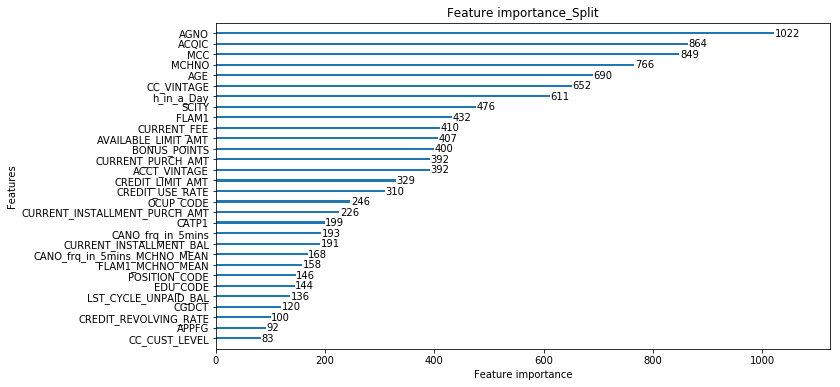

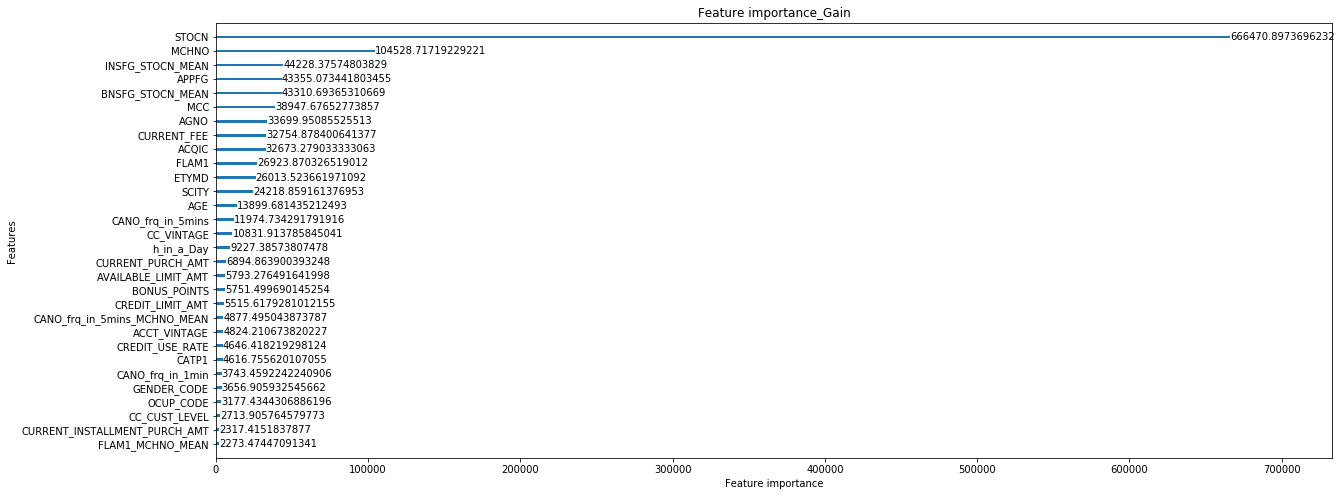

In [314]:
#對test算performance
LGBM_grid_measure = measure_performance(X = X_test, y = y_test, clf = LGBM_grid_final, show_classification_report=True, show_confusion_matrix=True)

# feature importances
print('Feature importances:', list(LGBM_grid_final.feature_importances_))
print(X_test.columns)

# visualization
print('Plot feature importances...')
split_importance = lgb.plot_importance(LGBM_grid_final_fit, max_num_features=30, ignore_zero=False,figsize=(11, 6),grid=False, title='Feature importance_Split')
gain_importance = lgb.plot_importance(LGBM_grid_final_fit, max_num_features=30, importance_type='gain',figsize=(20, 8),grid=False, title='Feature importance_Gain')


In [315]:
#對test算 f1_score
from sklearn.metrics import f1_score
y_pred_val = LGBM_grid_final_fit.predict(X_test)
f1_score(y_test,y_pred_val,average=None)

array([0.98816066, 0.92514908])

### 透過 F1 cumulative results檢視成效

In [316]:
def get_lift(prob_data):
    prob_data=prob_data.sort_values(by=['Prob'],ascending=False).reset_index(drop=True)
    prob_data['cnt']=1.0
    prob_data['cumsum']=prob_data.Y.cumsum()
    prob_data['cum_cnt'] = prob_data.cnt.cumsum()
    prob_data['precision'] = prob_data['cumsum']/prob_data['cum_cnt']
    prob_data['recall'] = prob_data['cumsum']/prob_data['cumsum'].max()
    lift_data = prob_data[['precision','recall']].groupby(['recall']).min().reset_index()
    lift_data['f1'] = (2*lift_data.precision*lift_data.recall)/(lift_data.precision+lift_data.recall)
    return lift_data

In [317]:
result = pd.DataFrame(data={'Y':y_test,'Prob':y_pred_val})
result_lift = get_lift(result)

In [318]:
result_lift=result_lift.iloc[1:,:]

In [319]:
result_lift[result_lift.f1==result_lift.f1.max()]

,recall,precision,f1
20089,0.91882,0.931559,0.925146


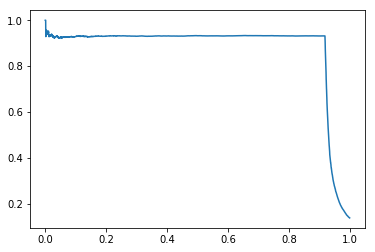

In [320]:
plt.plot(result_lift.recall,result_lift.precision)

In [321]:
#拿全部的dataTrain來建
LGBM_grid_final_fit_all = LGBM_grid_final.fit(X_feature, y_t)

In [322]:
LGBM_grid_final_fit_res =LGBM_grid_final_fit_all.predict_proba(dataTest)

In [323]:
df_p = pd.DataFrame({'p0':LGBM_grid_final_fit_res[:,0],'p1':LGBM_grid_final_fit_res[:,1]})

In [324]:
submit=pd.read_csv('sampleSubmission.csv',encoding='big5')
out = pd.concat([submit, df_p], axis=1, ignore_index=True)
out.sort_values(by=[3], ascending=False, inplace=True)
out.rename(columns={0:'TXKEY', 1:'FRAUD_IND', 2:'p0', 3:'p1'},inplace=True)
print('偽冒機率門檻：',out.iloc[1438,3])#1634=1438/0.88
out.FRAUD_IND[out.p1>=out.iloc[1438,3]]=1

偽冒機率門檻： 0.9460727730085692


In [325]:
ttl= out['FRAUD_IND'].sum()
ttl

1442

In [326]:
out=out[['TXKEY','FRAUD_IND']]
out.to_csv("submit.csv", index= False)

In [119]:
print('This submission: public score: 0.43037 and private score: 0.38258')

This submission: public score: 0.43037 and private score: 0.38258


In [ ]:
%pwd